In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from sklearn.decomposition import PCA
from accelerate import KMeans

In [ ]:
# Data loader
DATA_DIR = Path('../data/embeddings')
block_names = [f"{i:03d}.parquet" for i in range(1)]

block_paths = [DATA_DIR / block_name for block_name in block_names]
blocks = [pd.read_parquet(block_path) for block_path in block_paths]
dataset = pd.concat(blocks, axis=0)

def flatten(column):
    return np.array([np.array(x) for x in column])

Loaded 1 blocks


Clustering 10000 tweets
torch.Size([10000, 1536])


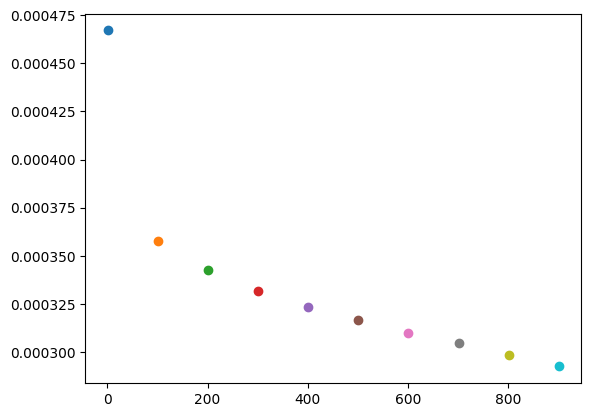

In [53]:
print(f"Clustering {dataset.shape[0]} tweets")

embedding_matrix = torch.from_numpy(flatten(dataset['embeddings'])).to('cuda:0')
print(embedding_matrix.shape)

for k in range(1, 1000, 100):
    labels, centers = KMeans(embedding_matrix, k)

    MSE = torch.mean((embedding_matrix - centers[labels])**2).cpu().numpy()

    plt.plot(k, MSE, 'o')


Reduced to 1926 tweets in 28 clusters
Best clusters: tensor([ 18, 325, 193, 250,  98,  96, 381, 429, 182, 450])
Class 18: 59 tweets
Class 325: 75 tweets
Class 193: 52 tweets
Class 250: 59 tweets
Class 98: 64 tweets
Class 96: 76 tweets
Class 381: 53 tweets
Class 429: 61 tweets
Class 182: 98 tweets
Class 450: 52 tweets


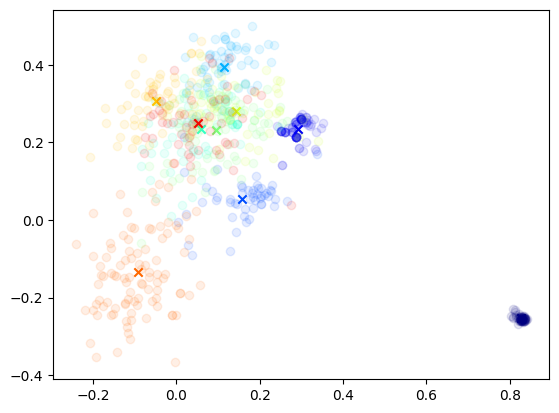

In [47]:
k = 500
min_posts = 50

class_labels, class_means = KMeans(embedding_matrix, k)

dataset["cluster"] = class_labels.cpu().numpy()

class_mse = np.zeros(k)
for i in range(k):
    class_mse[i] = torch.mean((embedding_matrix[class_labels == i] - class_means[i])**2).cpu().numpy()

class_sizes = np.array([torch.sum(class_labels == i).cpu().numpy() for i in range(k)])

# filter out clusters with less than min_posts
large_clusters = torch.from_numpy(np.array(np.where(class_sizes > min_posts))).to('cuda:0')

embeddings = embedding_matrix[torch.isin(class_labels, large_clusters)]
class_labels = class_labels[torch.isin(class_labels, large_clusters)]

print(f"Reduced to {embeddings.shape[0]} tweets in {len(large_clusters[0])} clusters")

# lowest MSE clusters
MSE = torch.mean((embeddings - class_means[class_labels])**2, dim=1)
class_MSE = torch.zeros(k) + torch.inf
for i in large_clusters.cpu().numpy().flatten():
    class_MSE[i] = torch.mean(MSE[class_labels == i])


# end of GPU
class_means = class_means.cpu().numpy()
class_labels = class_labels.cpu().numpy()
embeddings = embeddings.cpu().numpy()

clusters_ranked = np.argsort(class_MSE)
best_clusters = clusters_ranked[0:10]

print(f"Best clusters: {best_clusters}")

# PCA for the top M clusters
pca = PCA(n_components=2)
pca.fit(class_means)
pca_mean = pca.transform(class_means)
pca_datapoints = pca.transform(embeddings)


cmap = plt.get_cmap('jet')

for i in range(len(best_clusters)):
    plt.scatter(pca_mean[best_clusters[i], 0], pca_mean[best_clusters[i], 1], color=cmap(i/len(best_clusters)), marker='x')

    pca_class_datapoints = pca_datapoints[class_labels == best_clusters[i]]
    print(f"Class {best_clusters[i]}: {pca_class_datapoints.shape[0]} tweets")
    plt.scatter(pca_class_datapoints[:, 0], pca_class_datapoints[:, 1], color=cmap(i/len(best_clusters)), alpha=0.1)